# Dreambooth inpainting finetuning e-commerce

In [ ]:
!pip install -U diffusers transformers ftfy gradio accelerate

In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1
#!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/research_projects/dreambooth_inpaint/train_dreambooth_inpaint.py

In [2]:
import inspect
from typing import List, Optional, Union
import numpy as np
import torch
import os
import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [1]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = PIL.Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [4]:
local_dir = "./images/necklace/"  # train images
inpaint_dir = "./images/inpainting/"  # target images and masks

if not os.path.exists(local_dir):
    os.makedirs(local_dir)
if not os.path.exists(inpaint_dir):
    os.makedirs(inpaint_dir)

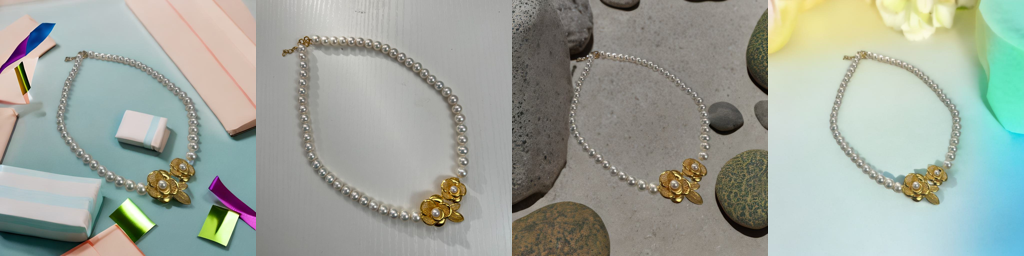

In [5]:
import glob
from PIL import Image

# change path to display images from your local dir
img_paths = f"{local_dir}*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 4
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [10]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Run inpainting model

In [6]:
from huggingface_hub import notebook_login
notebook_login()

Train your own inpainting model

In [15]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_inpaint.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-inpainting"  \
    --instance_data_dir="images/necklace" \
    --output_dir="stable-diffusion-inpainting-necklace" \
    --instance_prompt="a photo of a sks necklace" \
    --resolution=512 \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=2 \
    --gradient_checkpointing \
    --train_text_encoder \
    --seed="0"
    #--push_to_hub

Steps: 100%|████████████| 500/500 [11:39<00:00,  1.24s/it, loss=0.0331, lr=5e-6]vae/diffusion_pytorch_model.safetensors not found

Loading pipeline components...:  14%|█▊           | 1/7 [00:00<00:00,  7.36it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.

Steps: 100%|████████████| 500/500 [12:34<00:00,  1.51s/it, loss=0.0331, lr=5e-6]


Test training results

In [13]:
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline

device = "cuda"

# Inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stable-diffusion-inpainting-necklace",
    torch_dtype=torch.float16,
)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
# Image and Mask
def inpaint(image, prompt, mask=None, n_samples=4, device='cuda', class_instance=None):
    image_pil = Image.open(os.path.join(inpaint_dir, image))
    if mask is not None:
        mask_image = Image.open(os.path.join(inpaint_dir, mask)).convert("RGB")
        print(mask_image)
    elif class_instance is not None:
        mask_image = predict_mask(os.path.join(inpaint_dir, image), class_instance)[-1]
    print(mask_image)
    print(type(mask_image))
    images = pipe(prompt=[prompt]*n_samples, image=image_pil, mask_image=mask_image).images
    return images

In [29]:
n_samples = 4
images = inpaint('necklace2.jpg', prompt="a photo of a sks necklace", mask='necklace2_mask.jpg', n_samples=n_samples)

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F8D321320B0>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7F8D321320B0>
<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

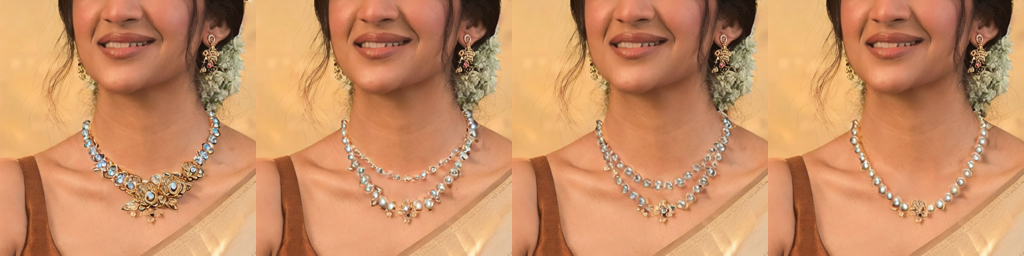

In [31]:
image_grid(images, 1, 4)

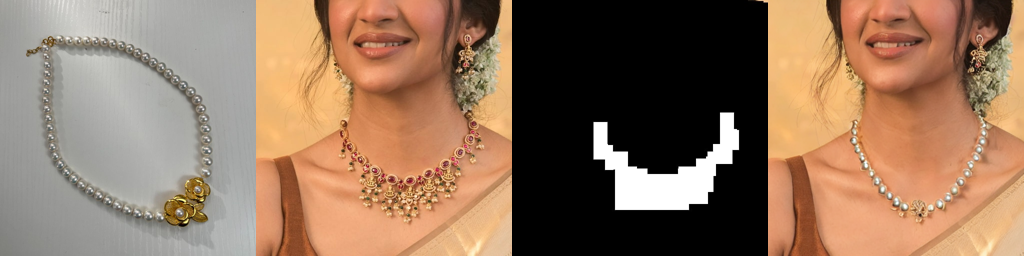

In [34]:
benchmark_images = [Image.open('images/necklace/necklace.jpg'), Image.open(os.path.join(inpaint_dir, 'necklace2.jpg')), Image.open(os.path.join(inpaint_dir, 'necklace2_mask.jpg')), images[3]]
image_grid(benchmark_images, 1, 4)

In [51]:
n_samples = 4
images = inpaint('necklace1.jpeg', prompt="a photo of a sks necklace, 8k ultra hd, exhibition, perfect composition", mask='necklace1_mask.jpeg', n_samples=n_samples)

<PIL.Image.Image image mode=RGB size=571x571 at 0x7F8D5D87B130>
<PIL.Image.Image image mode=RGB size=571x571 at 0x7F8D5D87B130>
<class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

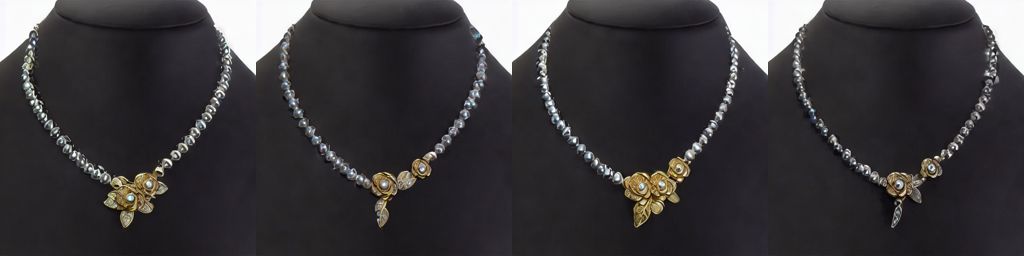

In [52]:
image_grid(images, 1, 4)

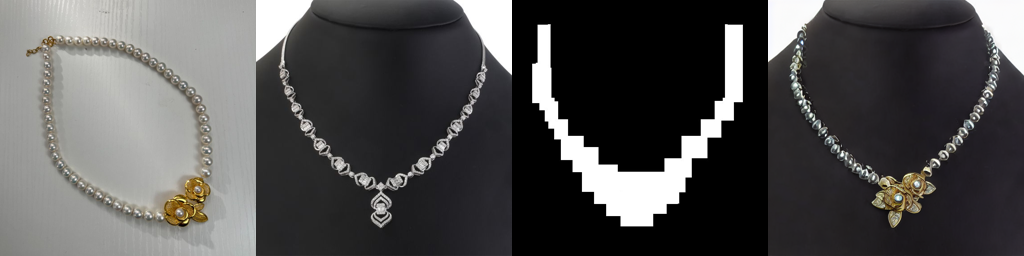

In [53]:
benchmark_images = [Image.open('images/necklace/necklace.jpg'), Image.open(os.path.join(inpaint_dir, 'necklace1.jpeg')), Image.open(os.path.join(inpaint_dir, 'necklace1_mask.jpeg')), images[0]]
image_grid(benchmark_images, 1, 4)